In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors
import torch.nn.functional as F

from torchvision.utils import make_grid

import random
import os
from itertools import product

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
# Die ersten beiden leaning Raten waren zu hoch, erste bei der letzen hat es funktioniert
# Wahrscheinlich ist das problem unabhängig von der Distance der Loss-function

batch_size: int = 32
#learning_rate: int = 0.001
#learning_rate: int = 0.0005
learning_rate: int = 0.00001

path_mnist_data: str = '/..Autoencoder/data'

device: str = "mps" if torch.backends.mps.is_available() else "cpu"
device: torch.device = torch.device(device)

In [3]:
#https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=20.0, verbose=0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        #for debugging
        self.verbose = verbose

    def forward(self, output1, output2, label):

        #euclidean_distance = torch.sqrt((output1 - output2) ** 2)
        
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        if self.verbose >= 1:
            print(f'distance between the two vektores {output1}-{output2}: {euclidean_distance}')
        #negativ_differenz = self.margin ** 2 - euclidean_distance ** 2
        #if self.verbose >= 1:
        #    print(negativ_differenz)


        bound_negativ_pair = torch.max(self.margin ** 2 - euclidean_distance, torch.tensor(0.0)) ** 2
        if self.verbose >= 1:
            print(f'bound negative pair:{bound_negativ_pair}')

       #https://dvl.in.tum.de/slides/adl4cv-ws20/2.Siamese.pdf 
        loss_contrastive = label * euclidean_distance ** 2 + (1 - label) * bound_negativ_pair
        if self.verbose >= 1:
            print(f'contrastive loss: {loss_contrastive}')    
        return loss_contrastive.mean()

## Datensatz Klasse für das Training von Sieamese networks
- download/import MNIST Dataste filepath="./Autoencoder/data"
- divide images in wanted kategories for example 0 and 9
- decice which amount of data should be used as labeld data
- create the cross product between all the the classes 

In [4]:
class Siamese_Dataset(torch.utils.data.Dataset):
    def __init__(self, file_path):
        super(Siamese_Dataset, self).__init__()

        '''
        Download mnist dataset and transoform data to a tensor
        '''
        transform = transforms.Compose([transforms.ToTensor()])
        mnist_dataset = datasets.MNIST(root='./Autoencoder/data', train=True, download=False, transform=transform)

        #Filtert die MNIST datensatz nach den gewüschten lables
        images_label_9 = list(filter(lambda x: x[1] == 9, mnist_dataset))
        #Extrahiere die Daten aus den gefilterten Ergenissen
        images_label_9 = [img[0] for img in images_label_9]

        images_label_0 = list(filter(lambda x: x[1] == 0, mnist_dataset))
        images_label_0 = [img[0] for img in images_label_0]

        # Anzahl der Bilder mit Label 0 und 9
        print(f"Anzahl der Bilder mit Label 0: {len(images_label_0)}")
        print(f"Anzahl der Bilder mit Label 9: {len(images_label_9)}")

        assert(len(images_label_9), len(images_label_0))

        percent_keept_data = 0.1
        number_keept_data = int(percent_keept_data * len(images_label_9))

        self.random_images_labeled_9 = random.sample(images_label_9, number_keept_data)
        self.random_images_labeled_0 = random.sample(images_label_0, number_keept_data)

        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 0: {len(self.random_images_labeled_0)}")
        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 9: {len(self.random_images_labeled_9)}")

        # Finde die Daten, die nicht ausgewählt wurden
        self.remaining_images_label_9 = list(set(images_label_9) - set(self.random_images_labeled_9))
        self.remaining_images_label_0 = list(set(images_label_0) - set(self.random_images_labeled_0))

        data_0 = list(product(self.random_images_labeled_0, repeat=2))
        data_9 = list(product(self.random_images_labeled_9, repeat=2))
        print("Beispielausgaben der Daten (Label 0):")
        self.print_examples(2, data_0)
        self.print_examples(2, data_9)

        data_combined = list(product(self.random_images_labeled_0, self.random_images_labeled_9))
        print("Beispielausgaben der Daten (Label 0 und Label 9):")
        self.print_examples(2, data_combined)

        data_labeled_1 = [(pair, 1) for pair in data_0 + data_9]
        data_labeled_0 = [(pair, 0) for pair in data_combined]

        self.data = data_labeled_1 + data_labeled_0

    def __len__(self):
        #assert(len(self.filtered_images), len(self.filtered_labels))
        return len(self.data)
    
    def __getitem__(self, idx):
        (img1, img2), label = self.data[idx]
        return img1, img2, label
        #image = self.filtered_images[idx]
        #label = self.filtered_labels[idx]
        #return image, label

    def get_data_0_9(self):
        return self.random_images_labeled_0, self.random_images_labeled_9
    
    def get_unlabeld_data_0_9(self):
        return self.remaining_images_label_0, self.remaining_images_label_9
    
    def print_examples(self, number_iterations: int, data: list[tuple]):
        for i in range(number_iterations):
            img1, img2 = data[i]
            print(f"data: ({img1.size()}, {img2.size()})")
            # Konvertiere Tensor in NumPy-Array und transponiere die Achsen, um das Bild korrekt darzustellen
            img1_np = img1.numpy().transpose((1, 2, 0))
            img2_np = img2.numpy().transpose((1, 2, 0))
    
            # Erstelle subplot und zeige die beiden Bilder an
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img1_np.squeeze(), cmap='gray')
            axs[0].set_title('Image 1')
            axs[1].imshow(img2_np.squeeze(), cmap='gray')
            axs[1].set_title('Image 2')
            plt.show()

<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/t_/1myf3wns5278ht8dnkq95ln80000gn/T/ipykernel_91253/3048646989.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(images_label_9), len(images_label_0))


Anzahl der Bilder mit Label 0: 5923
Anzahl der Bilder mit Label 9: 5949
Anzahl der zufällig ausgewählten Bilder mit Label 0: 594
Anzahl der zufällig ausgewählten Bilder mit Label 9: 594
Beispielausgaben der Daten (Label 0):
data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


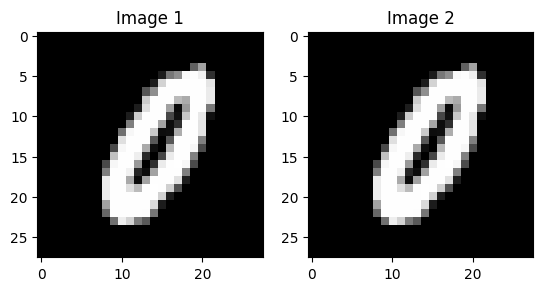

data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


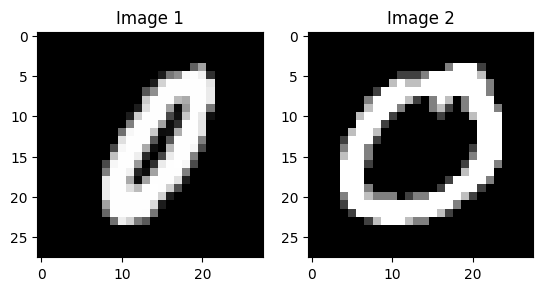

data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


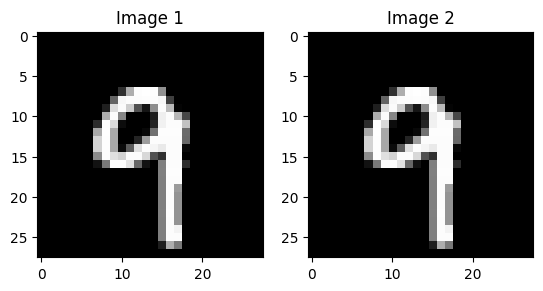

data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


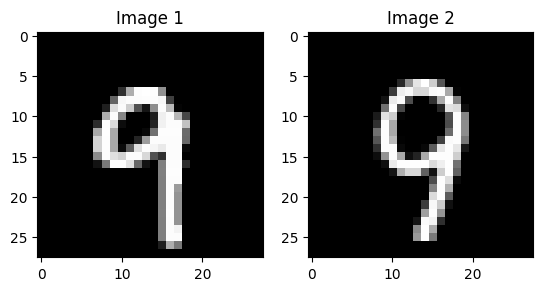

Beispielausgaben der Daten (Label 0 und Label 9):
data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


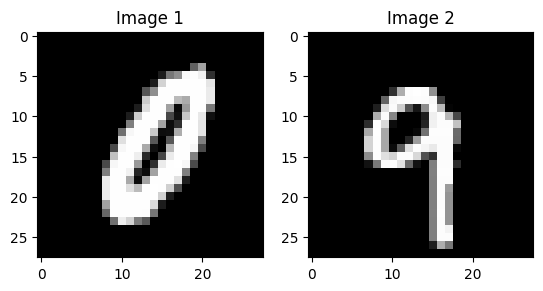

data: (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))


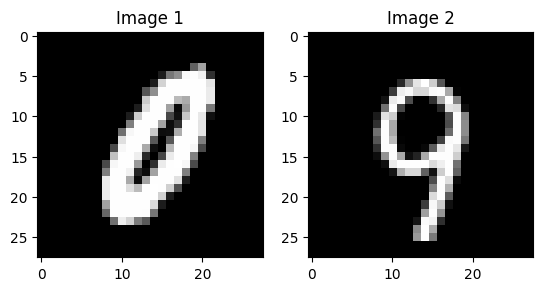

In [5]:
dataset_09 = Siamese_Dataset('./Siamese/mnist_filtered_09.pt')
loader_09 = DataLoader(
    dataset = dataset_09,
    batch_size = batch_size,
    shuffle=True,
)

In [6]:
print('Training Set:\n')
for image1, image2, labels in loader_09:
    print('Image batch dimensions:', image1.size())
    print('Image batch dimensions:', image2.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [7]:
# Siamese network mit nur einen pfard
# Der zweite pfard wird erstellt, indem das model einfach nochmal durchlaufen wird im training

# Es besteht auch die Möglichkeit beide durchläufe in einem netz zu machen

class Seamese_network(nn.Module):
    def __init__(self) -> None:
        super(Seamese_network, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5))
            #nn.LeakyReLU(negative_slope=0.1),
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 5))
            #nn.LeakyReLU(negative_slope=0.1),
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 32)
    
    """
    Mit der leaky relu Aktivierungsfunktion(negative slope= 0.1) explodiert die loss:
    ----------------Start trainign Epoche 0----------------
    Epoche: 0 Average Loss: 31.96145576324463
    ----------------Start trainign Epoche 1----------------
    Epoche: 1 Average Loss: 5036.7331955078125
    ----------------Start trainign Epoche 2----------------
    Epoche: 2 Average Loss: 168627.32698125
    ----------------Start trainign Epoche 3----------------
    Epoche: 3 Average Loss: 1005168.5827666667

    Bei der normalen relu -> function lernt der algorithmus
    """


    # hängt sich auf bei 2.0866666
    def forward_once(self, x) -> torch.Tensor:
        x = self.conv1(x)
        #x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.max_pool1(x)
        x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.conv2(x)
        #x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.max_pool2(x)
        x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x, y) -> torch.Tensor:
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)
        return out1, out2
        

network: Seamese_network = Seamese_network().to(device)
print(network)

Seamese_network(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
)


In [8]:
print(f'Output Size der einzelnen layern im Encoder')
input_tensor_network = torch.randn(64, 1, 28, 28).to(device)
with torch.no_grad():
    output = input_tensor_network
    for name, layer in network.named_children():
        if name == "fc1":
            output = output.view(-1, 16 * 4 * 4)
        output = layer(output)
        print(f"{name}: {output.size()}")

Output Size der einzelnen layern im Encoder
conv1: torch.Size([64, 8, 24, 24])
max_pool1: torch.Size([64, 8, 12, 12])
conv2: torch.Size([64, 16, 8, 8])
max_pool2: torch.Size([64, 16, 4, 4])
fc1: torch.Size([64, 64])
fc2: torch.Size([64, 32])


In [9]:
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

loss_func = ContrastiveLoss(margin=5.0)

data0, data9 = dataset_09.get_unlabeld_data_0_9()

list_latend_space = []
list_epoch_loss = [] 
loss_iteration = []
for epoch in range(20):
    print(f'----------------Start trainign Epoche {epoch}----------------')
    epoch_loss: float = 0.0
    epoch_latends = []
    epoch_labels = []
    for (images_1, images_2, targets) in loader_09:
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

        output1, output2 = network(images_1, images_2)
        #output2 = network(images_2)
        #atend_space = encoder_model(inputs)
        #outputs = decoder_model(latend_space)
        loss = loss_func(output1, output2, targets)
        loss.backward()
        optimizer.step()
        iteration_loss = loss.item()
        loss_iteration.append(iteration_loss)
        #epoch_loss += loss.item()
        epoch_loss += loss.item()
        #del images_1, images_2, output1, output2, loss
        #epoch_latends.append(output1)
        #epoch_latends.append(output2) 

    list_epoch_loss.append(epoch_loss/len(loader_09))

    for x,y in zip(data0, data9):
        x, y = x.to(device), y.to(device)
        output1, output2 = network(x, y)
        epoch_latends.append(output1)
        epoch_labels.append(0)
        epoch_latends.append(output2)
        epoch_labels.append(9)
    embedes = epoch_latends#.to("cpu").detach().numpy()
    embedes_lables = epoch_labels#.to("cpu").detach().numpy()
    #------------ print latend umd zu sehen was passiert---------
    #tnse = TSNE(n_components=2, random_state=42)
    #features_2d = tnse.fit_transform(embedes)

    #plt.figure(figsize=(10,7))
    #scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embedes_lables, cmap='viridis', alpha=0.6)
    #plt.colorbar(scatter)
    #plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
    #plt.xlabel('t-SNE Dimension 1')
    #plt.ylabel('t-SNE Dimension 2')
    #plt.show()
    #-------------- ende des prints ------------------------
    tupel = (epoch_latends, epoch_labels)
    list_latend_space.append(tupel)
    print(f'Epoche: {epoch} Average Loss: {epoch_loss/len(loader_09)}')

----------------Start trainign Epoche 0----------------
Epoche: 0 Average Loss: 13.32695100914989
----------------Start trainign Epoche 1----------------
Epoche: 1 Average Loss: 0.7884160180439118
----------------Start trainign Epoche 2----------------
Epoche: 2 Average Loss: 0.3668356531476264
----------------Start trainign Epoche 3----------------
Epoche: 3 Average Loss: 0.2961953411101142
----------------Start trainign Epoche 4----------------
Epoche: 4 Average Loss: 0.30705382446700874
----------------Start trainign Epoche 5----------------
Epoche: 5 Average Loss: 0.4626398487053441
----------------Start trainign Epoche 6----------------
Epoche: 6 Average Loss: 2.2214055700280717
----------------Start trainign Epoche 7----------------
Epoche: 7 Average Loss: 1.4498513719355448
----------------Start trainign Epoche 8----------------
Epoche: 8 Average Loss: 2.5406379533627037
----------------Start trainign Epoche 9----------------
Epoche: 9 Average Loss: 1.745342723725911
-----------

In [10]:
# Zusammenfassen des latendspaces pro Epoche
latend_space_epoch: list((torch.Tensor, torch.Tensor)) = []
for i, (latend_spaces, labels) in enumerate(list_latend_space):
    embeded: torch.Tensor = latend_spaces[0] # First Embeded Tensor for each epoch
    embeded_labels: torch.Tensor = torch.tensor([labels[0]]) # First Label for each epoch
    if len(latend_spaces) != len(labels): # Check if len labels and epoch is simlar, if not something went wrong
        print("Fehler")
        break
    for i in range(1,len(latend_spaces)): # itereate over all training iterations per epoch
        embeded = torch.cat((embeded, latend_spaces[i]), 0)
        embeded_labels =  torch.cat((embeded_labels, torch.tensor([labels[i]])), 0)
    
    latend_space_epoch.append((embeded, embeded_labels)) # Write the combined embededs and labels per epoch to array

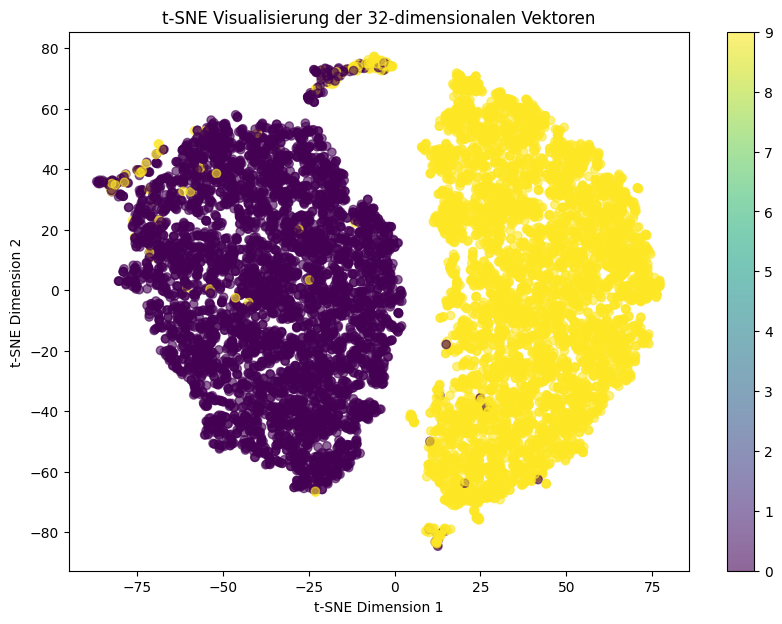

In [58]:
embeded = latend_space_epoch[19][0].to("cpu").detach().numpy()
embeded_label = latend_space_epoch[19][1].to("cpu").detach().numpy()

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

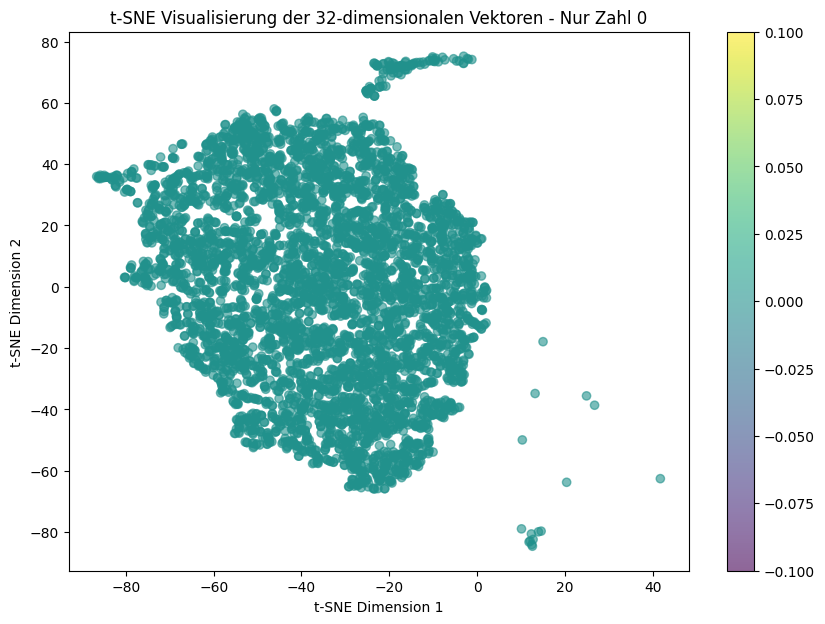

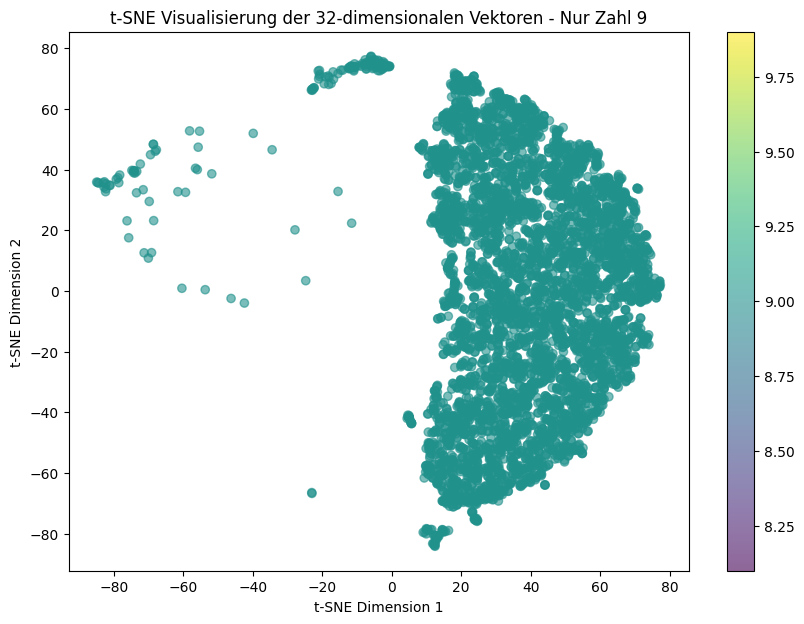

In [59]:
# Filtere die Daten für die Zahl 0
mask_0 = embeded_label == 0
features_2d_0_save = features_2d[mask_0]
labels_0 = embeded_label[mask_0]

# Filtere die Daten für die Zahl 9
mask_9 = embeded_label == 9
features_2d_9_save = features_2d[mask_9]
labels_9 = embeded_label[mask_9]

# Erstelle den Scatter-Plot für die Zahl 0
plt.figure(figsize=(10, 7))
scatter_0 = plt.scatter(features_2d_0_save[:, 0], features_2d_0_save[:, 1], c=labels_0, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_0)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 0')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Optional: Erstelle den Scatter-Plot für die Zahl 9
plt.figure(figsize=(10, 7))
scatter_9 = plt.scatter(features_2d_9_save[:, 0], features_2d_9_save[:, 1], c=labels_9, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_9)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 9')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

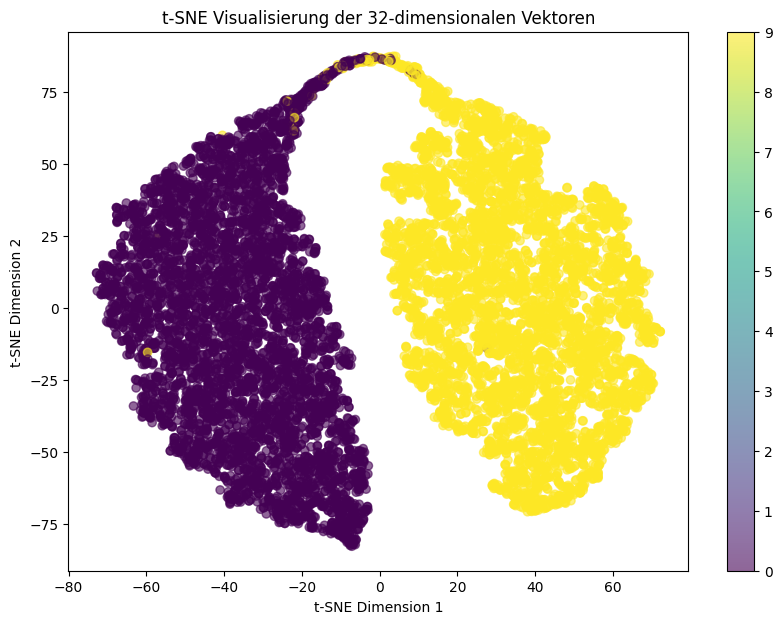

In [13]:
embeded = latend_space_epoch[0][0].to("cpu").detach().numpy()
embeded_label = latend_space_epoch[0][1].to("cpu").detach().numpy()

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

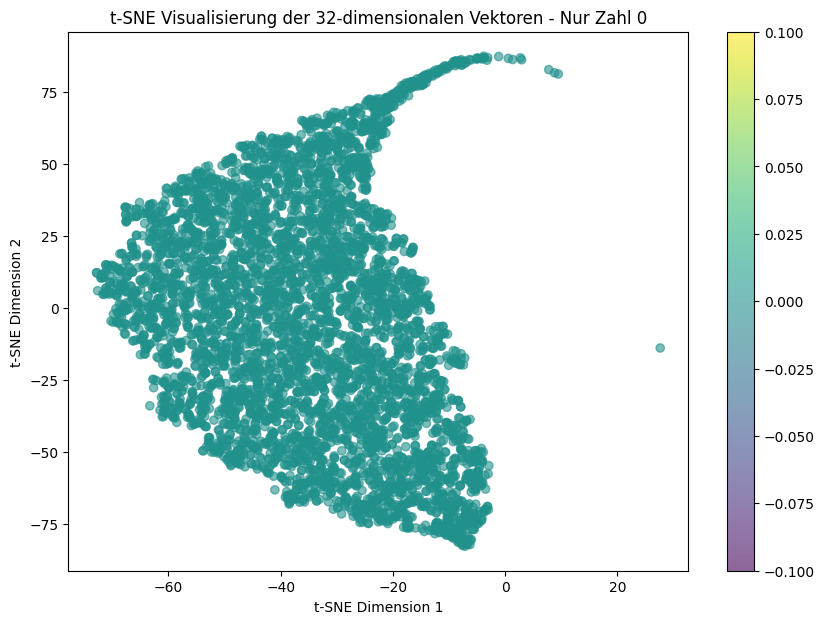

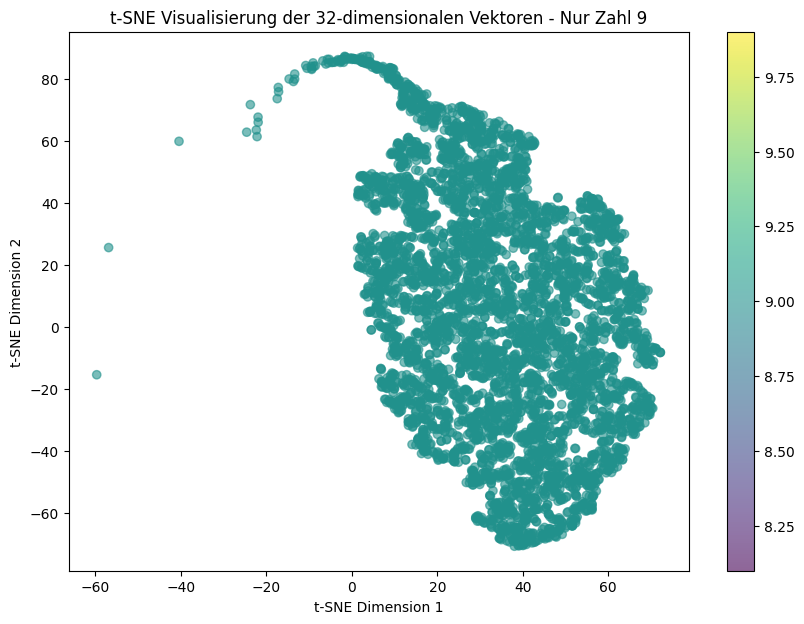

In [14]:
# Filtere die Daten für die Zahl 0
mask_0 = embeded_label == 0
features_2d_0 = features_2d[mask_0]
labels_0 = embeded_label[mask_0]

# Filtere die Daten für die Zahl 9
mask_9 = embeded_label == 9
features_2d_9 = features_2d[mask_9]
labels_9 = embeded_label[mask_9]

# Erstelle den Scatter-Plot für die Zahl 0
plt.figure(figsize=(10, 7))
scatter_0 = plt.scatter(features_2d_0[:, 0], features_2d_0[:, 1], c=labels_0, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_0)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 0')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Optional: Erstelle den Scatter-Plot für die Zahl 9
plt.figure(figsize=(10, 7))
scatter_9 = plt.scatter(features_2d_9[:, 0], features_2d_9[:, 1], c=labels_9, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_9)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 9')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

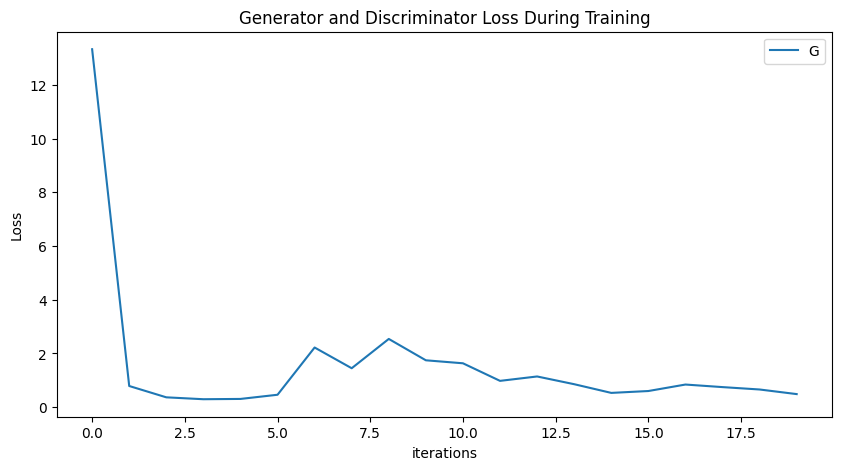

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(list_epoch_loss,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

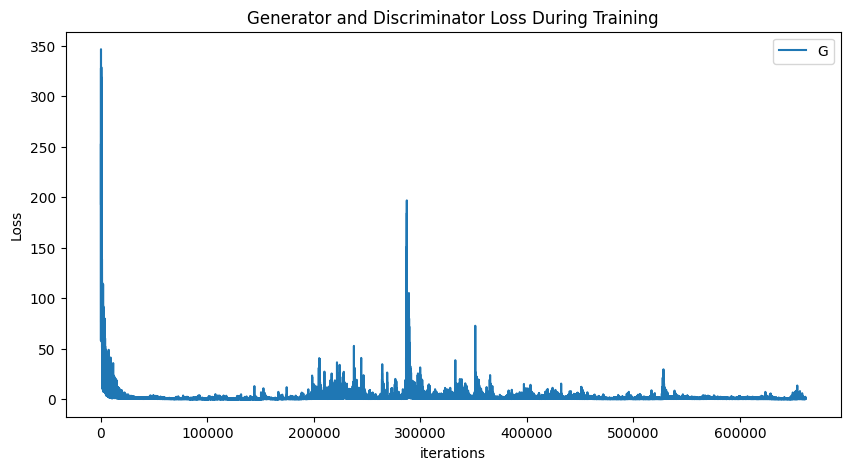

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_iteration,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
torch.save(network.state_dict(), './Models/siamese.pt')

In [46]:
data_0, data_9 = dataset_09.get_data_0_9()

embeded_0 = []
embeded_9 = []

for x,y in zip(data0, data9):
    x, y= x.to(device), y.to(device)
    out1, out2 = network(x, y)
    embeded_0.append(out1)
    embeded_9.append(out2)

print(type(embeded_0))
print(type(embeded_9))

print(type(embeded_0[0]))
print(len(embeded_9))


<class 'list'>
<class 'list'>
<class 'torch.Tensor'>
5329


In [166]:
print(embeded_0[0].to("cpu").detach().numpy())

embeded_numpy_0  = [tensor.to("cpu").squeeze().detach().numpy() for tensor in embeded_0]
embeded_numpy_9  = [tensor.to("cpu").squeeze().detach().numpy() for tensor in embeded_9]

print(embeded_numpy_0[0])
# Überprüfe die Dimensionen
print(f"Dimension of first embeded_0 vector: {embeded_0[0].shape}")
print(f"Dimension of first embeded_9 vector: {embeded_9[0].shape}")

embeded = np.array(embeded_numpy_0 + embeded_numpy_9)
embeded_label = [0] * len(embeded_numpy_0) + [9] *len(embeded_numpy_9)

print(len(embeded))

# Stelle sicher, dass all_embeddings eine 2D-Array-Struktur hat
if embeded.ndim != 2:
    raise ValueError(f"Expected 2D array, got {embeded.ndim}D array instead")


tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

NameError: name 'embeded_0' is not defined

In [167]:
np.savez('Siamese/label_0.npz', embedding_0_label=embeded_numpy_0)
np.savez('Siamese/label_9.npz', embedding_9_label=embeded_numpy_9)
np.savez('Siamese/unlabel_0.npz', embedding_0_unlabel=features_2d_0_save)
np.savez('Siamese/unlabel_9.npz', embedding_9_unlabel=features_2d_9_save)

NameError: name 'embeded_numpy_0' is not defined

## SimSiam with phi-model

In [287]:
# Siamese network mit nur einen pfard
# Der zweite pfard wird erstellt, indem das model einfach nochmal durchlaufen wird im training

# Es besteht auch die Möglichkeit beide durchläufe in einem netz zu machen

class Seamese_Phi_Model(nn.Module):
    def __init__(self) -> None:
        super(Seamese_Phi_Model, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(5, 5)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Conv2d(8, 16, kernel_size=(5, 5)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
        )
        self.predictor =  nn.Sequential(
            nn.Linear(16 * 4 * 4, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(100, 64),
        )
        self.projection = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
        )

        self.prediction = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10,1),
        )
    
    def forward(self, x) -> torch.Tensor:
        x = self.backbone(x)
        x = x.view(-1, 16 * 4 * 4)
        z = self.predictor(x)
        p = self.projection(z)
        out = self.prediction(p)
        out = F.sigmoid(out)
        z = z.detach()
        return p, z, out
        

model: Seamese_Phi_Model = Seamese_Phi_Model().to(device)
print(model)

Seamese_Phi_Model(
  (backbone): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.6, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.6, inplace=False)
  )
  (predictor): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=100, out_features=64, bias=True)
  )
  (projection): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
  (prediction): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU(inplace=Tru

In [288]:
print(f'Output Size der einzelnen layern im Encoder')
input_tensor_network = torch.randn(64, 1, 28, 28).to(device)
with torch.no_grad():
    output = input_tensor_network
    for name, layer in model.named_children():
        if name == 'predictor':
            output = output.view(-1, 16 * 4 * 4)
        print(f'{name}')
        output = layer(output)
        print(f"{name}: {output.size()}")

Output Size der einzelnen layern im Encoder
backbone
backbone: torch.Size([64, 16, 4, 4])
predictor
predictor: torch.Size([64, 64])
projection
projection: torch.Size([64, 64])
prediction
prediction: torch.Size([64, 1])


In [289]:
class Siamese_Phi_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super(Siamese_Phi_Dataset, self).__init__()

        '''
        Download mnist dataset and transoform data to a tensor
        '''
        transform = transforms.Compose([transforms.ToTensor()])
        mnist_dataset = datasets.MNIST(root='./Autoencoder/data', train=True, download=False, transform=transform)

        #Filtert die MNIST datensatz nach den gewüschten lables
        images_label_9 = list(filter(lambda x: x[1] == 9, mnist_dataset))
        #Extrahiere die Daten aus den gefilterten Ergenissen
        images_label_9 = [img[0] for img in images_label_9]

        images_label_0 = list(filter(lambda x: x[1] == 0, mnist_dataset))
        images_label_0 = [img[0] for img in images_label_0]

        # Anzahl der Bilder mit Label 0 und 9
        print(f"Anzahl der Bilder mit Label 0: {len(images_label_0)}")
        print(f"Anzahl der Bilder mit Label 9: {len(images_label_9)}")

        percent_keept_data = 0.1
        number_keept_data = int(percent_keept_data * len(images_label_9))

        self.random_images_labeled_9 = random.sample(images_label_9, number_keept_data)
        self.random_images_labeled_0 = random.sample(images_label_0, number_keept_data)

        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 0: {len(self.random_images_labeled_0)}")
        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 9: {len(self.random_images_labeled_9)}")

        # Finde die Daten, die nicht ausgewählt wurden
        self.remaining_images_label_9 = list(set(images_label_9) - set(self.random_images_labeled_9))
        self.remaining_images_label_0 = list(set(images_label_0) - set(self.random_images_labeled_0))

        self.train_data = np.append(self.random_images_labeled_9, self.random_images_labeled_0, axis=0)
        self.train_data = np.append(self.train_data, self.remaining_images_label_9, axis=0)
        self.train_data = np.append(self.train_data, self.remaining_images_label_0, axis=0)
        self.lables = [1] * len(self.random_images_labeled_9) + [0] * len(self.random_images_labeled_0) + [-1] * len(self.remaining_images_label_0) + [-1]  * len(self.remaining_images_label_9)
        self.lables = np.array(self.lables)
        assert(len(self.train_data) == len(self.lables))
    def __len__(self):
        #assert(len(self.filtered_images), len(self.filtered_labels))
        return len(self.train_data)
    
    def __getitem__(self, idx):
        item = self.train_data [idx]
        lable = self.lables[idx]
        return torch.tensor(item, dtype=torch.float32), torch.tensor(lable, dtype=torch.float32)
    
    def print_examples(self, number_iterations: int, data: list[tuple]):
        for i in range(number_iterations):
            img1, img2 = data[i]
            print(f"data: ({img1.size()}, {img2.size()})")
            # Konvertiere Tensor in NumPy-Array und transponiere die Achsen, um das Bild korrekt darzustellen
            img1_np = img1.numpy().transpose((1, 2, 0))
            img2_np = img2.numpy().transpose((1, 2, 0))
    
            # Erstelle subplot und zeige die beiden Bilder an
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img1_np.squeeze(), cmap='gray')
            axs[0].set_title('Image 1')
            axs[1].imshow(img2_np.squeeze(), cmap='gray')
            axs[1].set_title('Image 2')
            plt.show()

In [290]:
dataset_phi_09 = Siamese_Phi_Dataset()
loader_phi_09 = DataLoader(
    dataset = dataset_phi_09,
    batch_size = 128,
    shuffle=True,
)

Anzahl der Bilder mit Label 0: 5923
Anzahl der Bilder mit Label 9: 5949
Anzahl der zufällig ausgewählten Bilder mit Label 0: 594
Anzahl der zufällig ausgewählten Bilder mit Label 9: 594


In [291]:
class Siames_Phi_Loss(nn.Module):
 
    def __init__(self):
        super(Siames_Phi_Loss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=-1, eps=1e-6)
        self.bce = nn.BCELoss()

    def forward(self, w, z0, p0, z1, p1, lable, target):
        # Bisher wied die cosine simulatiry benutz nicht die negative cosine simularity

        # Berechnung der Cosine Similarity
        cosine_sim_0 = - self.cosine_similarity(p0, z1)  + 1
        cosine_sim_1 = - self.cosine_similarity(p1, z0)  + 1
        
       # Berechnung des Cosine Similarity Loss
        cosine_sim_loss = w * 0.5 * (cosine_sim_0 + cosine_sim_1)

        # Berechnung des BCE Loss
        bce_loss = F.binary_cross_entropy(lable, target, reduction='none') * 2

        # Kombination der Verluste mit torch.where
        loss = torch.where(target == -1, cosine_sim_loss, bce_loss)
        loss_bce = torch.where(target == -1, 0, bce_loss)
        loss_cosine = torch.where(target == -1, cosine_sim_loss, 0)

        #print(f'Die erste cosine simularity ist: {cosine_sim_0}')
        #print(f'Die zweite cosine simularity ist: {cosine_sim_1}')
        #print(f'Die bce istt: {bce_loss}')
        #print(f'Die targets sind: {target}')
        #print(lable.mean())
        #return loss.mean()
        #loss = torch.where(target == -1, w * 0.5 * ( - self.cosine_similarity(p0, z1) - self.cosine_similarity(p1, z0) + 2), F.mse_loss(lable, target, reduction='none'))
        return loss.mean(), loss_cosine.mean(), loss_bce.mean()

In [292]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

phi_loss = Siames_Phi_Loss()

list_latend_space = []
list_epoch_loss = [] 
loss_iteration = []
for epoch in range(40):
    print(f'----------------Start trainign Epoche {epoch}----------------')
    epoch_loss: float = 0.0
    epoch_bce: float = 0.0
    epoch_cosine: float = 0.0
    epoch_latends = []
    epoch_labels = []
    for (inp, target) in loader_phi_09:
        inp, target = inp.to(device), target.to(device)

        p0, z0, out =  model(inp)
        p1, z1, _ = model(inp)
        target = target.unsqueeze(1)
        loss, cosine, bce = phi_loss(w=0.4, z0=z0, p0=p0, z1=z1, p1=p1, lable=out, target=target)
        loss.backward()
        optimizer.step()
        iteration_loss = loss.item()
        loss_iteration.append(iteration_loss)
        epoch_loss += loss.item()
        epoch_bce += bce.item()
        epoch_cosine += cosine.item()
        epoch_latends.append(p0.to("cpu").detach().numpy())
        epoch_labels.append(target.to("cpu").detach().numpy())
    tupel = (epoch_latends, epoch_labels)
    list_latend_space.append(tupel)
    list_epoch_loss.append(epoch_loss/len(loader_phi_09))
    print(f'Epoche: {epoch} Average Loss: {epoch_loss/len(loader_phi_09)}, Average BCE: {epoch_bce/len(loader_phi_09)}, Average Cosine: {epoch_cosine/len(loader_phi_09)}')


----------------Start trainign Epoche 0----------------
Epoche: 0 Average Loss: 0.4796251199578726, Average BCE: 0.13939609755110996, Average Cosine: 0.34022902192608
----------------Start trainign Epoche 1----------------
Epoche: 1 Average Loss: 0.4460813329424909, Average BCE: 0.13968635819131328, Average Cosine: 0.30639497695430634
----------------Start trainign Epoche 2----------------
Epoche: 2 Average Loss: 0.4082467402181318, Average BCE: 0.14102039622363224, Average Cosine: 0.26722633998881107
----------------Start trainign Epoche 3----------------
Epoche: 3 Average Loss: 0.3833582273093603, Average BCE: 0.14494488913045134, Average Cosine: 0.23841333581555274
----------------Start trainign Epoche 4----------------
Epoche: 4 Average Loss: 0.380524448169175, Average BCE: 0.15977691786904488, Average Cosine: 0.22074753366490846
----------------Start trainign Epoche 5----------------
Epoche: 5 Average Loss: 0.431277286301377, Average BCE: 0.21819040920304997, Average Cosine: 0.213

KeyboardInterrupt: 

In [ ]:
print(len(list_latend_space))
print(type(list_latend_space[0]))


40
<class 'tuple'>


In [ ]:
latend_space_epoch = []

for i, (latend_spaces, labels) in enumerate(list_latend_space):
    embeded = np.array(latend_spaces[0])  # First Embeded Tensor für jede Epoche
    embeded_labels = np.array([labels[0]])  # First Label für jede Epoche

    if len(latend_spaces) != len(labels):  # Überprüfen, ob die Länge von Labels und Epoch ähnlich ist
        print("Fehler")
        break

    for j in range(1, len(latend_spaces)):  # Iteriere über alle Training-Iterationen pro Epoche
        embeded = np.vstack((embeded, np.array(latend_spaces[j])))
        embeded_labels = np.hstack((embeded_labels, np.array([labels[j]])))

    latend_space_epoch.append((embeded, embeded_labels))  # Schreibe die kombinierten Embededs und Labels pro Epoche ins Array


In [ ]:
print(len(latend_space_epoch))
print(type(latend_space_epoch))
print(latend_space_epoch[0][1])
print(latend_space_epoch[0][0])

40
<class 'list'>
[[[-1.]
  [-1.]
  [-1.]
  ...
  [ 0.]
  [-1.]
  [-1.]]]
[[ 6.74676575e+02  2.22912025e+01 -3.55932007e+02 ...  1.12696204e+03
  -1.02293994e+03 -1.40648523e+03]
 [ 6.05764282e+02  2.60179672e+01 -3.24462555e+02 ...  9.53545105e+02
  -8.92421753e+02 -1.22607971e+03]
 [ 7.17216919e+02 -1.31893969e+00 -3.74851654e+02 ...  1.11896094e+03
  -1.03672852e+03 -1.43692688e+03]
 ...
 [ 8.07071655e+02  6.37577343e+00 -4.32584381e+02 ...  1.33921716e+03
  -1.23372949e+03 -1.68484192e+03]
 [ 6.94454468e+02 -3.57249260e+00 -3.84486969e+02 ...  1.21762781e+03
  -1.09924536e+03 -1.49968652e+03]
 [ 1.10387097e+03  1.80567112e+01 -6.25086975e+02 ...  1.91908252e+03
  -1.73711316e+03 -2.36569849e+03]]


In [ ]:
# Filtere die Liste, um nur die Werte zu behalten, die nicht -1 sind
filtered_latend_space_epoch = []

for embeded, labels in latend_space_epoch:
    # Labels abflachen, um eine 1D-Maske zu erstellen
    labels_flat = labels.flatten()
    # Maske erstellen, die angibt, welche Werte nicht -1 sind
    mask = labels_flat != -1
    # Eingebettete Werte und Labels entsprechend der Maske filtern
    filtered_embeded = embeded[mask]
    filtered_labels = labels_flat[mask]
    # Nur hinzufügen, wenn die gefilterten Arrays nicht leer sind
    if filtered_embeded.size > 0 and filtered_labels.size > 0:
        filtered_latend_space_epoch.append((filtered_embeded, filtered_labels))

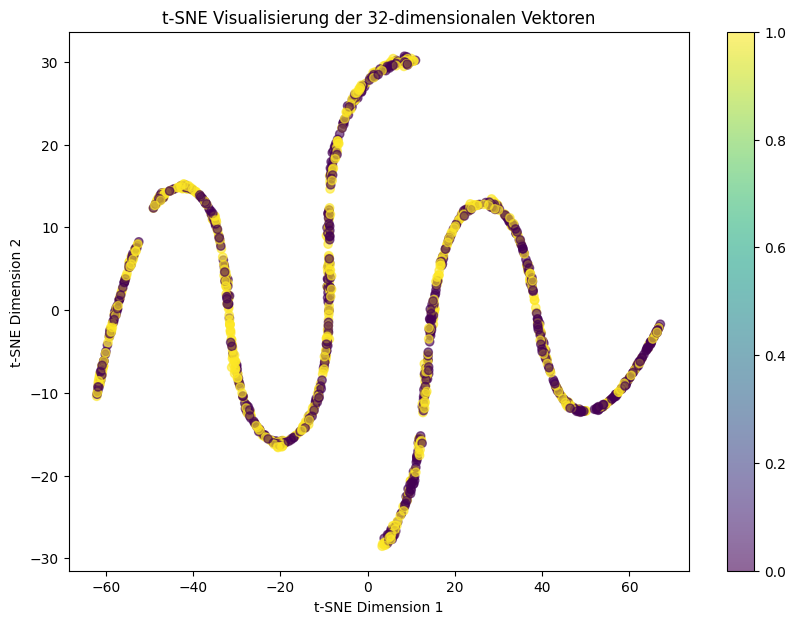

In [ ]:
embeded = filtered_latend_space_epoch[39][0]
embeded_label = filtered_latend_space_epoch[39][1]

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

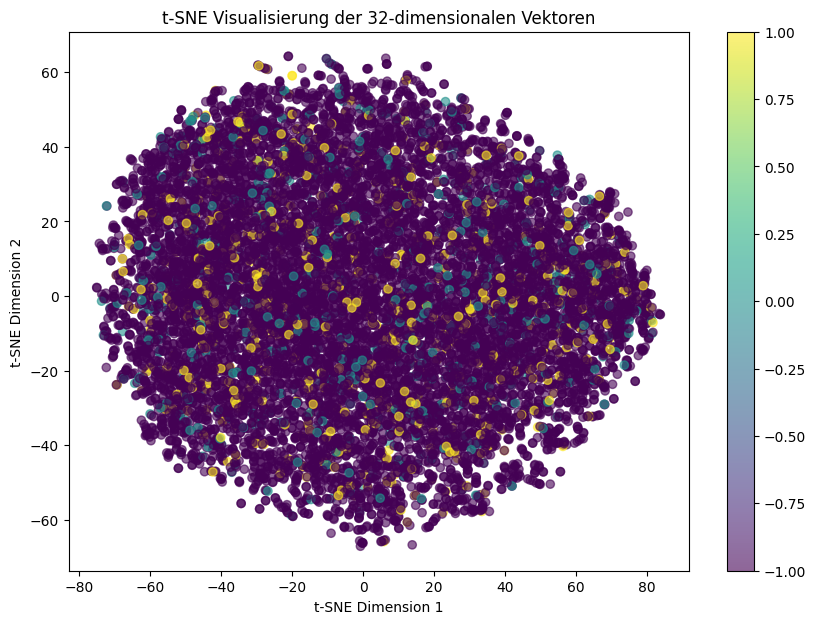

In [129]:
embeded = latend_space_epoch[0][0]
embeded_label = latend_space_epoch[0][1]

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

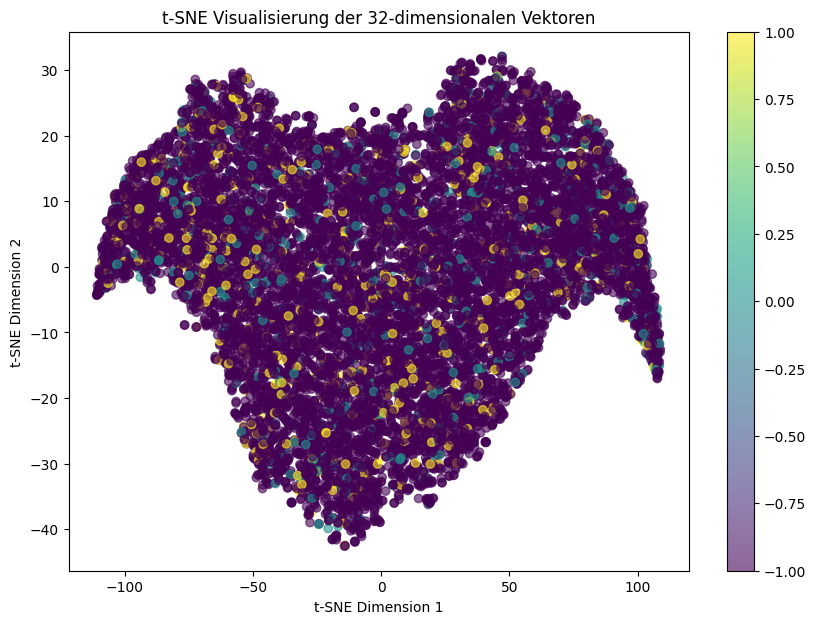

In [130]:
embeded = latend_space_epoch[19][0]
embeded_label = latend_space_epoch[19][1]

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# Beispielhaftes Latent-Space-Objekt latend_space_epoch
# Angenommen, latend_space_epoch ist definiert wie folgt:
# latend_space_epoch = [(embeded, embeded_label), ...]

# Beispielwerte für Demonstration
embeded = np.random.randn(100, 32)  # Beispiel für eingebettete Vektoren
embeded_label = np.random.randint(0, 10, size=100)  # Beispiel für Labels

# Verwendung von UMAP anstelle von t-SNE
umap_reducer = umap.UMAP(n_components=2, random_state=42)
features_2d = umap_reducer.fit_transform(embeded)

# Plotten der Ergebnisse
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('UMAP Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


AttributeError: module 'umap' has no attribute 'UMAP'

In [333]:
# Siamese network mit nur einen pfard
# Der zweite pfard wird erstellt, indem das model einfach nochmal durchlaufen wird im training

# Es besteht auch die Möglichkeit beide durchläufe in einem netz zu machen

class SimSiam(nn.Module):
    def __init__(self) -> None:
        super(SimSiam, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(5, 5)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Conv2d(8, 16, kernel_size=(5, 5)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
        )
        self.predictor =  nn.Sequential(
            nn.Linear(16 * 4 * 4, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(100, 64),
        )
        self.projection = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
        )
    
    def forward(self, x) -> torch.Tensor:
        x = self.backbone(x)
        x = x.view(-1, 16 * 4 * 4)
        z = self.predictor(x)
        p = self.projection(z)
        z = z.detach()
        return p, z
        

simsiam: SimSiam = SimSiam().to(device)
print(simsiam)

SimSiam(
  (backbone): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.6, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.6, inplace=False)
  )
  (predictor): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=100, out_features=64, bias=True)
  )
  (projection): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
)


In [334]:
class SimSiam_Loss(nn.Module):
 
    def __init__(self):
        super(SimSiam_Loss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=-1, eps=1e-6)

    def forward(self, p0, z0, p1, z1):
        cosine_1 = - self.cosine_similarity(p0, z1)
        #print(f'Cosine1: {cosine_1}')
        cosine_2 = - self.cosine_similarity(p1, z0)
        #print(f'Cosine1: {cosine_2}')
        loss = 0.5 * (cosine_1 + cosine_2)
        #print(f'loss: {loss}')
        return loss.mean()

In [335]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

simsiam_loss = SimSiam_Loss()

list_latend_space = []
list_epoch_loss = [] 
loss_iteration = []
for epoch in range(40):
    print(f'----------------Start trainign Epoche {epoch}----------------')
    epoch_loss: float = 0.0
    epoch_bce: float = 0.0
    epoch_cosine: float = 0.0
    epoch_latends = []
    epoch_labels = []
    for (inp, target) in loader_phi_09:
        inp, target = inp.to(device), target.to(device)

        p0, z0 =  simsiam(inp)
        p1, z1 = simsiam(inp)
        loss = simsiam_loss(p0, z0, p1, z1)
        loss.backward()
        optimizer.step()
        iteration_loss = loss.item()
        loss_iteration.append(iteration_loss)
        epoch_loss += loss.item()
        epoch_latends.append(p0.to("cpu").detach().numpy())
        epoch_labels.append(target.to("cpu").detach().numpy())
    tupel = (epoch_latends, epoch_labels)
    list_latend_space.append(tupel)
    list_epoch_loss.append(epoch_loss/len(loader_phi_09))
    print(f'Epoche: {epoch} Average Loss: {epoch_loss/len(loader_phi_09)}')


----------------Start trainign Epoche 0----------------
Epoche: 0 Average Loss: -0.11790212884705553
----------------Start trainign Epoche 1----------------
Epoche: 1 Average Loss: -0.11677248014878201
----------------Start trainign Epoche 2----------------
Epoche: 2 Average Loss: -0.11700622416952605
----------------Start trainign Epoche 3----------------
Epoche: 3 Average Loss: -0.1169269757084949
----------------Start trainign Epoche 4----------------
Epoche: 4 Average Loss: -0.11704148504362312
----------------Start trainign Epoche 5----------------
Epoche: 5 Average Loss: -0.11653394636607939
----------------Start trainign Epoche 6----------------
Epoche: 6 Average Loss: -0.11593169614832888
----------------Start trainign Epoche 7----------------
Epoche: 7 Average Loss: -0.11630539107386784
----------------Start trainign Epoche 8----------------
Epoche: 8 Average Loss: -0.11623406538399317
----------------Start trainign Epoche 9----------------
Epoche: 9 Average Loss: -0.116597054

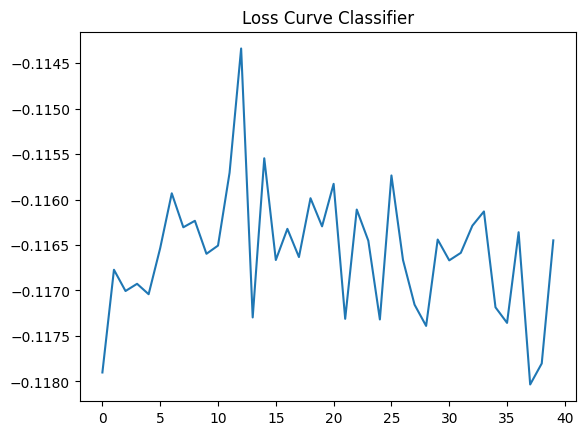

In [336]:
plt.plot(list_epoch_loss)
plt.title('Loss Curve Classifier')
plt.show()

In [337]:
latend_space_epoch = []

for i, (latend_spaces, labels) in enumerate(list_latend_space):
    embeded = np.array(latend_spaces[0])  # First Embeded Tensor für jede Epoche
    embeded_labels = np.array([labels[0]])  # First Label für jede Epoche

    if len(latend_spaces) != len(labels):  # Überprüfen, ob die Länge von Labels und Epoch ähnlich ist
        print("Fehler")
        break

    for j in range(1, len(latend_spaces)):  # Iteriere über alle Training-Iterationen pro Epoche
        embeded = np.vstack((embeded, np.array(latend_spaces[j])))
        embeded_labels = np.hstack((embeded_labels, np.array([labels[j]])))
    latend_space_epoch.append((embeded, embeded_labels))  # Schreibe die kombinierten Embededs und Labels pro Epoche ins Array



In [338]:
print(len(latend_space_epoch))
print(len(list_latend_space))

40
40


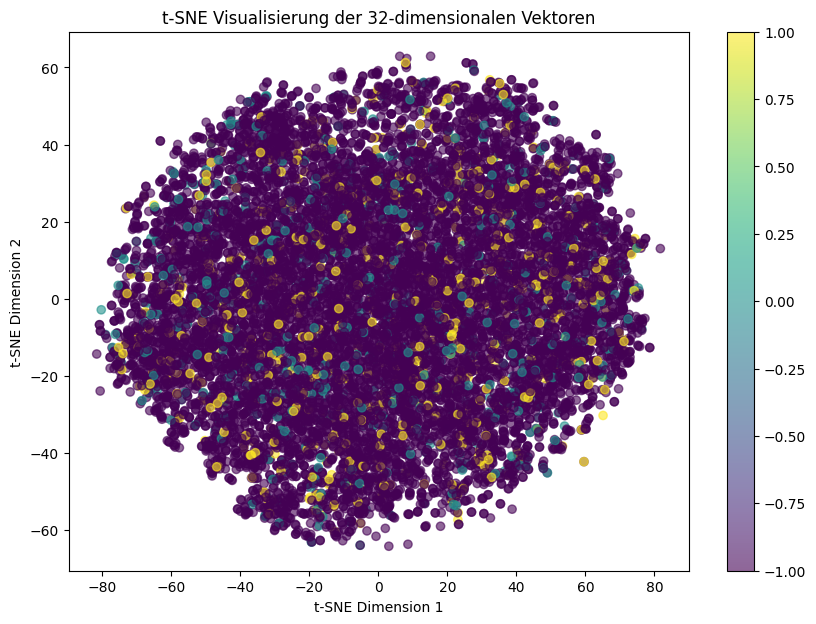

In [332]:
embeded = latend_space_epoch[39][0]
embeded_label = latend_space_epoch[39][1]

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()